# 卷积操作与自定义算子开发

卷积是卷积神经网络中的基本操作，对于图像的特征提取有着关键的作用。本实验首先介绍卷积的基本原理与作用，然后通过编写程序实现卷积操作，并展示了均值、高斯与sobel等几种经典卷积核的卷积效果，接着调用MindSpore中的卷积算子Conv2d来实现卷积操作，最后介绍了MindSpore中pyfunc和TBE两种自定义算子实现方法。

通过本次实验，希望同学们能深入理解卷积的特点、作用、参数以及计算过程，掌握编程实现卷积操作的方法，了解几种经典卷积核的作用，并学会MindSpore中的卷积算子的调用方法，掌握pyfunc和TBE类型的自定义算子开发方式。

## 1、卷积的基本原理

### 1.1 卷积的概念

+ 卷积操作发展于信号处理领域，主要用于削弱原始信号中混入的噪声，典型的应用场景还有对于某个线性时不变的系统，给定输入信号和系统响应，来求系统的输出。

+ 卷积操作引入到深度学习领域后，卷积神经网络得到了极大的发展，卷积核中的所有权重都是随机初始化，而不是一开始确定的，网络每次更新迭代都是为了寻找一个最合适的卷积核权重值。

+ 卷积与互相关有着千丝万缕的关系，对于二维卷积而言，将卷积核左右翻转、上下翻转，再将其与输入图片进行互相关运算，与直接卷积运算在输出结果上是等价的，目前各个深度学习框架的卷积层的API对于卷积运算的实现使用的是互相关运算。

### 1.2 卷积的计算过程

二维卷积操作相当于将卷积核作为一个滑动窗口，将其在输入张量上从左至右、从上至下地滑动，每滑动一下便将卷积核与其相应位置计算出一个加权系数，作为输出张量对应位置上的像素值。其计算过程为：将输入的张量与卷积核进行卷积操作，得到输出矩阵并将其返回。

步长为1的卷积过程如下图所示：

<div align=center>
<img src="./images/卷积示意图.png" width="50%" height="50%" />
</ div>

### 1.3 卷积的参数

卷积的参数有步长stride、填充pad、卷积核大小、深度、数量等等。其中：

+ 步长表示卷积核在输入张量上每次滑动的步距，通过设置大于1的步长可以减少输出张量的大小。

+ 填充表示在输入张量的周围填补行或列的多少。

+ 卷积核的深度与输入张量的深度相同，卷积核的数量决定了输出张量的深度。

### 1.4 输出图片大小的计算公式

输出图片大小的计算如下：

$$res_h = ((data_h + 2*pad_h - filter_h) / stride_h) + 1 \tag{1}$$

$$res_w = ((data_w + 2*pad_w - filter_w) / stride_w) + 1 \tag{2}$$

其中：

+ $res_h$、$res_w$为输出图片的高度与宽度

+ $data_h$、$data_w$为输入图片的高度与宽度

+ $pad_h$、$pad_w$为高度与宽度方向上的补边

+ $filter_h$、$filter_w$为卷积核的高度与宽度

+ $stride_h$、$stride_w$为高度与宽度方向上的步长

### 1.5 卷积的作用

卷积操作可以实现数据降维、特征提取等任务，通过设置不同的步长、补边与卷积核大小等参数，能够提取到图像不同的特征，完成不同的图像处理任务。

在图像处理中，卷积核也称为滤波器，如常用的均值滤波与高斯滤波能够起到图像平滑和锐化的效果，而sobel算子和Laplace算子对于图像的边缘检测有较好的效果。

## 2、卷积的程序实现

### 2.1 卷积计算的公式推导及数据转化关系

设有两个函数$f_{1}(t)$和$f_{2}(t)$，卷积$f(t)$的公式为：

$$f(t)=\int_{-\infty}^{\infty} f_{1}(\tau) f_{2}(t-\tau) d \tau =f_{1}(t) \otimes f_{2}(t)\tag{3}$$

其中$ \otimes$被称作**张量积**。

对于机器视觉中的卷积处理，通常采用互相关运算加以完成。**互相关**（Cross-Correlation）是一个衡量两个序列相关性的函数，通常是用滑动窗口的点积计算来实现。给定一个图像$x$和卷积核$w$，它们的互相关为：

$$y_{i j}=\sum_{u=1}^{m} \sum_{v=1}^{n} w_{u v} \cdot x_{i+u-1, j+v-1}\tag{4}$$

其中，$y$为卷积输出图像；$i,j$下标为图像内每一像素点的索引；$u,v$下标为卷积核内每一位置的索引；卷积核的大小为$m*n$；图像大小为$M*N$

**数据转化关系**：

为了能实现卷积一次性处理大量图像数据，并能在一次卷积中使用多个卷积核的功能，先对图像$x$和卷积核$w$做出计算上的数据格式定义：

对于输入图像$x$，设其输出变量为四维张量Data:

$$Data = [B_i,C_i,H_i,W_i]\tag{5}$$

其中$B_i$表示一次训练所选取的样本数；$C_i$表示输入数据的通道数/深度；$H_i$表示输入数据二维平面的高度height；$W_i$表示输入数据二维平面的宽带width

卷积对应的输出数据同样为四维张量res：

$$res = [B_o,C_o,H_o,W_o] \tag{6}$$

其中$B_o$表示一次训练所选取的样本数；$C_o$表示输出数据的通道数/深度；$H_o$表示输出数据二维平面的高度height；$W_o$输出数据二维平面的宽带width

对于卷积核$w$，设其数据为四维张量Weight：

$$Weight = [C_i,C,H_f,W_f]\tag{7}$$

其中$C_i$表示卷积核的深度，在数值上必须和输入数据的深度相同；$C$表示卷积核的个数；$H_f$表示卷积核二维平面的高度height；$W_f$表示卷积核二维平面的宽带width

输出与输入数据的转化关系为：

$$B_o = B_i\tag{8}$$

$$C_o = C\tag{9}$$

$$H_o = ((H_i + 2*P_h - H_f) / S_h) + 1\tag{10}$$

$$W_o = ((W_i + 2*P_w - W_f) / S_w) + 1\tag{11}$$

其中，$P_h$和$P_w$分别表示数据在height和width的填充长度；$S_h$和$S_w$分别表示卷积在height和width的步长

### 2.2 卷积的程序实现

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline
def conv_compute(Data, Weight, para_dict):
    """
    The compute function of conv.
    data format:
        Data[batch,channel_in,data_h,data_w]
        Weight[channel_in, channel_out, filter_h, filter_w]
        para_dict{"pad_h":pad_h, "pad_w":pad_w, "stride_h":stride_h, "stride_w":stride_w}
        res[batch,channel_out,res_h,res_w]
    Parameter relationship:
        res_h = ((data_h + 2*pad_h - filter_h) / stride_h) + 1
        res_w = ((data_w + 2*pad_w - filter_w) / stride_w) + 1
    """
    # 1、获取para_dict中相关的参数
    pad_h = para_dict["pad_h"]  # 数据在h方向的补边
    pad_w = para_dict["pad_w"]  # 数据在w方向的补边
    stride_h = para_dict["stride_h"]  # 卷积在h方向的步长
    stride_w = para_dict["stride_w"]  # 卷积在w方向的步长

    # 2、获取数据和卷积核的尺寸
    N, _, H, W = Data.shape
    C_out = Weight.shape[0]
    filter_h = Weight.shape[2]
    filter_w = Weight.shape[3]

    # 3、对Data进行填充(补0)
    Data = np.pad(Data, ((0, 0), (0, 0), (pad_h, pad_h), (pad_w, pad_w)), 'constant')

    # 4、确定输出参数并定义输出矩阵res
    res_h = int(((H + 2 * pad_h - filter_h) / stride_h) + 1)
    res_w = int(((W + 2 * pad_w - filter_w) / stride_w) + 1)
    res = np.zeros((N, C_out, res_h, res_w))

    # 5、利用numpy进行卷积运算
    for n in range(0, N):  # batch层
        for c in range(0, C_out):  # chanel_out层
            res_i = 0
            for h in range(0, Data.shape[2]-filter_h+1, stride_h):
                res_j = 0
                for w in range(0, Data.shape[3]-filter_w+1, stride_w):
                    # 互相关运算的程序实现：
                    res[n, c, res_i, res_j] = \
                        np.sum(np.multiply(
                            Data[n, :, h:h+filter_h, w:w+filter_w], Weight[:, c, :, :]))
                    res_j = res_j + 1
                res_i = res_i + 1

    return res

## 3、卷积操作演示

在信号处理、图像处理、深度学习等领域，卷积运算都是一种十分基础有效且应用广泛的数据处理技术。在实际应用中通过设置不同的卷积核、调整卷积参数可以实现对数据降维、特征识别与提取等功能。

导入测试图像并转为Data格式：

In [2]:
# 1、导入图像：
img = cv2.imread(r'./images/lena.png', 0)

# 2、利用numpy将图像转化成Data格式
img = np.array(img)
data_img = img.reshape((1, 1, img.shape[0], img.shape[1]))

### 3.1 补充数据边缘的pad参数

在神经网络等卷积需要重复在一组数据上操作的领域中，每次因为卷积而造成的数据减小不利于整个计算流程的设计，因此保证数据在卷积过程中不会改变大小是很有必要的。pad参数应这一需求而出，pad通过提前增加数据大小（通常时对数据边缘进行补0操作）来实现卷积过程中数据的大小不变。通过对上面变换公式进行逆推演可以得出在卷积不改变数据大小时数据需要提前补边的公式：

$$pad_h = (filter_h - 1) / 2\tag{12}$$

$$pad_w = (filter_w - 1) / 2\tag{13}$$

In [3]:
# 定义一个由随机数据组成的卷积核
np.random.seed(4)
kernel_rand = np.random.randint(0, 5, (3, 3))
weight_rand = kernel_rand.reshape((1, 1, kernel_rand.shape[0], kernel_rand.shape[1]))

# 1、定义不进行补边和进行补边的卷积参数：
para_dict_nopad = {"pad_h": 0, "pad_w": 0,
                   "stride_h": 1, "stride_w": 1}
para_dict_pad = {"pad_h": int((kernel_rand.shape[0]-1)/2), "pad_w": int((kernel_rand.shape[1]-1)/2),
                 "stride_h": 1, "stride_w": 1}
# 2、实现卷积
res_pad = conv_compute(data_img, weight_rand,
                       para_dict_pad)  # 卷积核采用之前定义的随机卷积核
res_nopad = conv_compute(data_img, weight_rand, para_dict_nopad)

# 3、可视化数据卷积前后的大小
print('卷积前数据的大小： ', data_img.shape)
print('没有补边操作卷积后的数据大小： ', res_nopad.shape)
print('有补边操作卷积后的数据大小： ', res_pad.shape)

卷积前数据的大小：  (1, 1, 256, 256)
没有补边操作卷积后的数据大小：  (1, 1, 254, 254)
有补边操作卷积后的数据大小：  (1, 1, 256, 256)


### 3.2 经典均值与高斯卷积——图像平滑和锐化

通过设置卷积核Weight内的参数可以实现对图像数据的均值平滑操作和特征锐化操作，即图像处理领域内的：均值滤波与高斯滤波。为方便演示，卷积核的大小统一为3 $\times$ 3。

用于均值滤波的卷积核：

$$ \frac{1}{9}\times\left[ \begin{array} {cccc}1&1&1\\ 1&1&1\\ 1&1&1\\ \end{array} \right]\tag{14} $$

用于高斯滤波的卷积核：

$$ \frac{1}{16}\times\left[ \begin{array} {cccc}1&2&1\\ 2&4&2\\ 1&2&1\\ \end{array} \right]\tag{15} $$

定义卷积核和卷积参数，对数据进行卷积操作并可视化卷积结果：

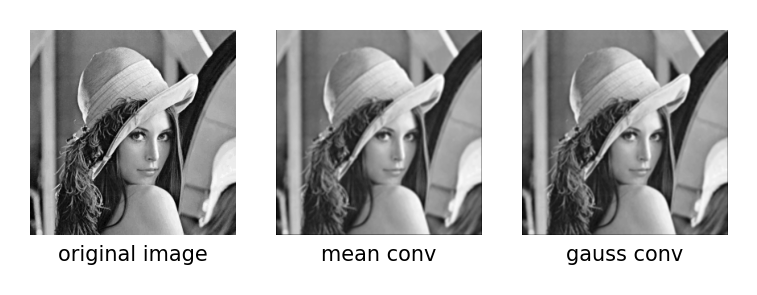

In [4]:
# 1、定义两种卷积的卷积核
kernel_mean = np.array([[1/9, 1/9, 1/9],
                        [1/9, 1/9, 1/9],
                        [1/9, 1/9, 1/9]])
weight_mean = kernel_mean.reshape((1, 1, kernel_mean.shape[0], kernel_mean.shape[1]))

kernel_gauss = np.array([[1/16, 2/16, 1/16],
                         [2/16, 4/16, 2/16],
                         [1/16, 2/16, 1/16]])
weight_gauss = kernel_gauss.reshape((1, 1, kernel_gauss.shape[0], kernel_gauss.shape[1]))

# 2、定义两种卷积的卷积参数：
para_dict_mean = {"pad_h": int((kernel_mean.shape[0]-1)/2), "pad_w": int((kernel_mean.shape[1]-1)/2),
                  "stride_h": 1, "stride_w": 1}

para_dict_gauss = {"pad_h": int((kernel_gauss.shape[0]-1)/2), "pad_w": int((kernel_gauss.shape[1]-1)/2),
                   "stride_h": 1, "stride_w": 1}

# 3、实现卷积
res_mean = conv_compute(data_img, weight_mean, para_dict_mean)
res_gauss = conv_compute(data_img, weight_gauss, para_dict_gauss)

# 4、可视化卷积结果
plt.figure(dpi=300, figsize=(3, 1))
plt.subplot(1, 3, 1)
plt.axis('off')  # 去掉边框及坐标轴
plt.title('original image', y=-0.25, size=5)
plt.imshow(img, cmap=plt.get_cmap('gray'))

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('mean conv', y=-0.25, size=5)
plt.imshow(res_mean[0, 0, :, :], cmap=plt.get_cmap('gray'))

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('gauss conv', y=-0.25, size=5)
plt.imshow(res_gauss[0, 0, :, :], cmap=plt.get_cmap('gray'))

plt.show()

### 3.3 一阶微分sobel卷积——某一方向的边缘检测

作为一阶微分算子的一种，sobel算子在Prewitt卷积算子的基础上进行改进，对中间的元素适当进行了加权，使得算子能够更好的检测图像数据的边缘特征。由于实现一阶微分的导数具有方向性，所以sobel卷积算子有8个方向（上、下、左、右、左上、左下、右上、右下），对应方向的sobel卷积算子可以检测物体在对应方向的边缘特征。下面以“下”方向的sobel卷积为例，展示sobel卷积操作能够提出图像数据中的边缘特征。

“下”方向的sobel卷积核：

$$ \left[ \begin{array} {cccc}-1&-2&-1\\ 0&0&0\\ 1&2&1\\ \end{array} \right] \tag{16}$$

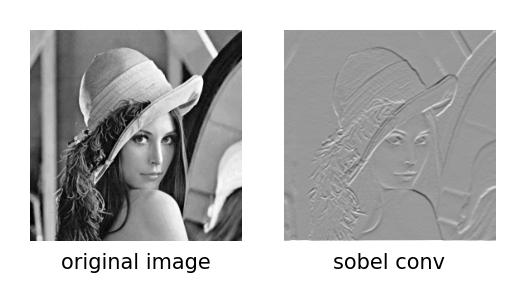

In [5]:
# 1、定义下方向的sobel卷积核
kernel_sobel = np.array([[-1, -2, -1],
                         [0, 0, 0],
                         [1, 2, 1]])
weight_sobel = kernel_sobel.reshape((1, 1, kernel_sobel.shape[0], kernel_sobel.shape[1]))

# 2、定义卷积参数：
para_dict_sobel = {"pad_h": int((kernel_sobel.shape[0]-1)/2), "pad_w": int((kernel_sobel.shape[1]-1)/2),
                   "stride_h": 1, "stride_w": 1}

# 3、实现卷积
res_sobel = conv_compute(data_img, weight_sobel, para_dict_sobel)

# 4、可视化卷积结果
plt.figure(dpi=300, figsize=(2, 1))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('original image', y=-0.25, size=5)
plt.imshow(img, cmap=plt.get_cmap('gray'))

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('sobel conv', y=-0.25, size=5)
plt.imshow(res_sobel[0, 0, :, :], cmap=plt.get_cmap('Greys'))

plt.show()

## 4、MindSpore中卷积算子的介绍与演示

在前面实验中，我们通过numpy库手动实现了卷积操作，并通过实例演示深入了解了卷积的实现原理、使用方式及调试方法。

在深度学习飞速发展的今天，很多学者往往需要一种能快速搭建神经网络的方式来节约自己宝贵的科研时间，从而将更多的精力用在提出和验证创新设想上。因此，华为公司提出了MindSpore深度学习框架，此框架内集成了包括卷积算子Conv2d在内的众多神经网络实现API，用户可以通过调用这些模块在短时间内高效地搭建出自己需要的深度学习网络，降低了编程难度，提高了科研效率。

MindSpore中的卷积API为：mindspore.nn.Conv2d, 详细可以参考[MindSpore官方API文档](https://www.mindspore.cn/docs/zh-CN/r1.8/api_python/nn/mindspore.nn.Conv2d.html?highlight=conv2d)

通过下面的代码介绍Conv2d的使用方法并可视化卷积结果：

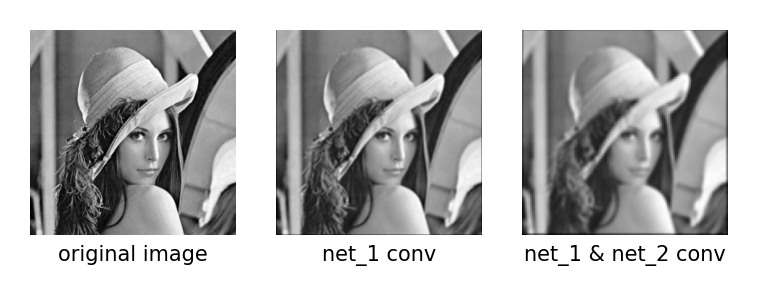

卷积前数据的大小：  (1, 1, 256, 256)
net_1参数卷积后数据的大小：  (1, 1, 256, 256)
net_1和net_2卷积后数据的大小：  (1, 1, 128, 128)


In [6]:
import mindspore
import mindspore.nn as nn
from mindspore import Tensor

# 1、将待卷积数据转化为mindspore.nn.Conv2d可接收的Tensor类型（numpy->Tensor）
data_img_ms = Tensor((data_img), mindspore.float32)
# 2、设置卷积参数net_1：(卷积核数量为1，尺寸为3*3，卷积步长为1)
net_1 = nn.Conv2d(1, 1, (3, 3), weight_init="ones")
# 3、对原始数据进行net_1参数下的卷积操作：
data_img_ms1 = net_1(data_img_ms)
# 4、设置卷积参数net_2：（卷积核数量为1，尺寸为5*5，卷积步长为2）
net_2 = nn.Conv2d(1, 1, (5, 5), stride=2, weight_init="ones")
# 5、对net_1参数卷积后的数据进行net_2参数下的卷积操作
data_img_ms2 = net_2(data_img_ms1)

# 6、可视化卷积结果
res_img_ms1 = data_img_ms1.asnumpy()  # 进行数据类型转换 Tensor -> numpy
res_img_ms2 = data_img_ms2.asnumpy()

plt.figure(dpi=300, figsize=(3, 1))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('original image', y=-0.25, size=5)
plt.imshow(img, cmap=plt.get_cmap('gray'))

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('net_1 conv', y=-0.25, size=5)
plt.imshow(res_img_ms1[0, 0, :, :], cmap=plt.get_cmap('gray'))

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('net_1 & net_2 conv', y=-0.25, size=5)
plt.imshow(res_img_ms2[0, 0, :, :], cmap=plt.get_cmap('gray'))

plt.show()

print('卷积前数据的大小： ', data_img.shape)
print('net_1参数卷积后数据的大小： ', res_img_ms1.shape)
print('net_1和net_2卷积后数据的大小： ', res_img_ms2.shape)

## 5、MindSpore中自定义卷积算子的pyfunc实现

前文提到：MindSpore中提供了包括卷积算子在内的大量内置算子。

虽然这些算子能够满足大多数深度学习的使用场景，但对于一些特殊任务来说，仍然有一定的局限性。

当开发网络遇到内置算子不足以满足需求时，可以利用MindSpore的Python API中的[Custom](https://www.mindspore.cn/docs/zh-CN/r1.8/api_python/ops/mindspore.ops.Custom.html#mindspore-ops-custom)原语方便快捷地进行不同类型自定义算子的定义和使用。

基于Custom原语的自定义算子支持的算子开发方式包括：pyfunc、hybrid、tbe、aicpu、aot、julia、akg。

### 5.1 pyfunc定义卷积算子原理

以pyfunc方式为例，实现在MindSpore中自定义卷积算子：

+ pyfunc类型的自定义算子使用原生Python语法定义算子实现函数，描述算子内部计算逻辑的实现。网络运行时框架会自动调用此函数。

+ 算子输出数据shape通过定义Python函数进行实现，描述算子输出shape的推导逻辑。

+ 算子输出数据类型dtype通过定义Python函数进行实现，描述算子输出dtype的推导逻辑。

### 5.2 pyfunc定义卷积算子程序实现

In [7]:
import numpy as np
import mindspore as ms
import mindspore.ops as ops
import cv2
from matplotlib import pyplot as plt

ms.set_context(device_target="CPU")

def conv_compute1(Data, Weight, para):
    """
    算子实现函数:

    无特殊说明外, 实现原理和参数变量与前文的基于numpy手动实现卷积算子的程序相同
    data format:
        Data[batch,channel_in,data_h,data_w]
        Weight[channel_in, channel_out, filter_h, filter_w]
        para[pad_h, pad_w, stride_h, stride_w]  #获取四维矩阵para, 以para的维度形状传递pad_h等卷积所需参数
        res[batch,channel_out,res_h,res_w]
    Parameter relationship:
        res_h = ((data_h + 2*pad_h - filter_h) / stride_h) + 1
        res_w = ((data_w + 2*pad_w - filter_w) / stride_w) + 1

    """
    # 1、获取para中传递的参数
    pad_h = para.shape[0]  # 数据在h方向的补边
    pad_w = para.shape[1]  # 数据在w方向的补边
    stride_h = para.shape[2]  # 卷积在h方向的步长
    stride_w = para.shape[3]  # 卷积在w方向的步长

    # 2、获取数据和卷积和的尺寸
    N, _, H, W = Data.shape
    C_out = Weight.shape[0]
    filter_h = Weight.shape[2]
    filter_w = Weight.shape[3]

    # 3、对Data进行补边(补0)
    Data = np.pad(Data, ((0, 0), (0, 0), (pad_h, pad_h), (pad_w, pad_w)), 'constant')

    # 4、确定输出参数并定义输出矩阵res
    res_h = int(((H + 2 * pad_h - filter_h) / stride_h) + 1)
    res_w = int(((W + 2 * pad_w - filter_w) / stride_w) + 1)
    res = np.zeros((N, C_out, res_h, res_w))


    # 5、利用numpy进行卷积运算
    for n in range(0, N):  # bath层
        for c in range(0, C_out):  # chanel_out层
            res_i = 0
            for h in range(0, Data.shape[2] - filter_h + 1, stride_h):
                res_j = 0
                for w in range(0, Data.shape[3] - filter_w + 1, stride_w):
                    # 互相关运算的程序实现：
                    res[n, c, res_i, res_j] = \
                        np.sum(np.multiply(
                            Data[n, :, h:h + filter_h, w:w + filter_w], Weight[:, c, :, :]))
                    res_j = res_j + 1
                res_i = res_i + 1

    return res

def infer_shape(Data, Weight, para):

    '''
    算子输出shape的推导函数:

    Input data format:
        接收算子实现函数中所用到的所有变量
        函数所接收的所有变量都是以list形式反应其形状shape
        例如: Data本来是一个四维矩阵
            但在这里Data是一个list[Data.shape[0], Data.shape[1], Data.shape[2], Data.shape[3]]
        即: 所有变量在这里只能得到其shape值, 不能得到变量中原有的数据值

    Onput data format:
        返回值是一个tuple类型的元组, 用来表示算子输出的数据的形状
        因此，推算的结果应该是一个元组
        当返回已知变量(如: Data)时，它会自动取变量的形状进行返回

    '''

    N = Data[0]     #直接获取Data的第一维度的值，相当于Data.shape[0]
    H = Data[2]
    W = Data[3]

    C_out = Weight[0]
    filter_h = Weight[2]
    filter_w = Weight[3]

    pad_h = para[0]
    pad_w = para[1]
    stride_h = para[2]
    stride_w = para[3]

    res_h = int(((H + 2 * pad_h - filter_h) / stride_h) + 1)
    res_w = int(((W + 2 * pad_w - filter_w) / stride_w) + 1)

    return (N, C_out, res_h, res_w)


def infer_dtype(Data, Weight, para):
    '''
    算子输出dtype的推导函数:

    Input data format:
        接收算子实现函数中所用到的所有变量
        函数所接收的所有变量都反应其形状dtype
        例如: Data本来是一个四维矩阵
            但在这里Data是一个Tensor[Float64]

    Onput data format:
        返回值是一个数据类型
        当返回已知变量(如: Data)时，它会自动取变量的数据类型进行返回

    '''

    #统一输入输出数据类型为：Tensor[Float64]，因此直接返回Data即可
    return Data

### 5.3 算子调用与效果展示

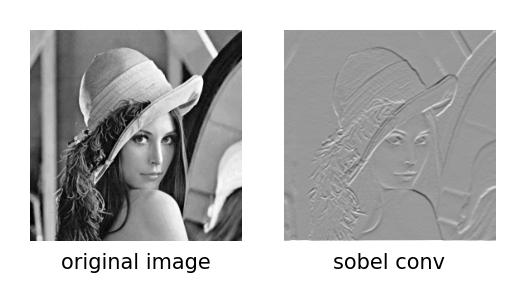

In [8]:
if __name__ == '__main__':
    #1、利用ops.Custom方法定义pyfunc类型的自定义算子
        # op = ops.Custom(para_1,out_shape,out_dtype,func_type)
        # 其中, op是定义后的算子
        # para_1填入自定义算子的计算函数名、out_shape和out_dtype填入对应的推理函数
        # func_type为自定义算子的方式的选择，选择“pyfunc”模式
    op = ops.Custom(conv_compute1,
                    out_shape=infer_shape,
                    out_dtype=infer_dtype,
                    func_type="pyfunc")

    # 2、导入图像并转化成Data格式：
    img = cv2.imread(r'./images/lena.png', 0)
    img = np.array(img)
    data_img = img.reshape((1, 1, img.shape[0], img.shape[1])).astype(np.float64)

    # 3、定义卷积核(以“下”方向的sobel卷积核为例)：
    kernel_sobel = np.array([[-1, -2, -1],
                             [0, 0, 0],
                             [1, 2, 1]])
    weight_sobel = kernel_sobel.reshape((1, 1, kernel_sobel.shape[0], kernel_sobel.shape[1])).astype(np.float64)

    # 4、定义卷积参数：
    para_sobel = np.zeros((int((kernel_sobel.shape[0]-1)/2), int((kernel_sobel.shape[1]-1)/2),
                           1, 1)).astype(int)

    # 5、实现卷积
    res_sobel = op(ms.Tensor(data_img), ms.Tensor(weight_sobel), ms.Tensor(para_sobel))
    res_sobel = res_sobel.asnumpy()   #利用mindspore.ops中内置方法.asnumpy()将Tensor类型的res_sobel转成numpy类型，
                                      #便于后续的可视化展示

    # 6、可视化卷积结果
    plt.figure(dpi=300, figsize=(2, 1))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title('original image', y=-0.25, size=5)
    plt.imshow(img, cmap=plt.get_cmap('gray'))

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title('sobel conv', y=-0.25, size=5)
    plt.imshow(res_sobel[0, 0, :, :], cmap=plt.get_cmap('Greys'))

    plt.show()

## 6、MindSpore中的TBE算子开发方式

#### 6.1 TBE简介

TBE（Tensor Boost Engine）提供了**基于TVM框架**的自定义算子开发能力，通过TBE提供的API和自定义算子编程开发界面可以完成相应神经网络算子的开发。TBE的逻辑架构如下图所示。

<div align=center>
<img src="./images/TBE图1.png" width="20%" height="20%" />
</div>

TBE内部包含了特性域语言（Domain-Specific Language，DSL）模块、调度（Schedule）模块、中间表示（Intermediate Representation，IR）模块、编译优化（Pass）模块以及代码生成（CodeGen）模块，如下图所示。

<div align=center>
<img src="./images/图2.png" width="20%" height="20%" />
</div>

+ **DSL模块**：面向开发者，提供算子逻辑的编写的接口（Compute接口），使用接口来编写算子。

+ **Schedule模块**：用于描述指定shape下算子如何在昇腾AI处理器上进行切分，包括Cube类算子的切分、Vector类算子的切分，它们仍然使用的是社区提供的调度原语来描述。

+ **IR模块**：借用社区的IR来表示，包括IR变形、AST树的维护等功能。

+ **编译优化（Pass）**：对生成的IR进行编译优化，优化的方式有双缓冲（Double Buffer）、流水线（Pipeline）同步、内存分配管理、指令映射、分块适配矩阵计算单元等。

+ **代码生成模块（CodeGen）**：CodeGen生成类C代码的临时文件，这个临时代码文件可以通过编译器生成算子的实现文件，可被网络模型直接加载调用。

#### 6.1.3 TBE算子开发方式

通过TBE进行算子开发有以下几种方式：

+ **DSL开发**

**DSL** (Domain-Specific Language) 特定域语言，是一种旨在特定领域下的上下文的语言。为了方便开发者进行自定义算子开发，昇腾AI软件栈借鉴了TVM中的TOPI机制，预先提供一些常用运算的调度，封装成一个个运算接口，称为基于TBE DSL（Domain-Specific Language）开发。开发者只需要利用这些特定域语言声明计算的流程，再使用自动调度（Auto Schedule）机制，指定目标生成代码，即可进一步被编译成专用内核。

+ **TIK开发**

**TIK** (Tensor Iterator Kernel)是一种基于Python语言的动态编程框架，呈现为一个Python模块，运行于Host CPU上。开发者可以通过调用TIK提供的API基于Python语言编写自定义算子，即TIK DSL，然后TIK编译器会将TIK DSL编译为昇腾AI处理器应用程序的二进制文件。基于TIK的自定义算子开发，提供了对Buffer的管理和数据自动同步机制，需要开发者对Davinci架构有一定的了解，但算子的schedule需要开发人员自己规划。

整个计算过程可以表现为多个输入张量经过一个计算节点得到多个张量的过程。TIK、DSL的开发流程本质上是一样的，只不过开发的抽象层次不一样而已。

#### 6.1.4 DSL开发方式

本实验主要采用DSL开发方式介绍自定义算子开发流程，下面详细介绍DSL方式的开发原理和步骤。

在DSL方式中，TBE提供了一套计算接口供开发者用于组装算子的计算逻辑，使得70%以上的算子可以基于这些接口进行开发，极大的降低自定义算子的开发难度。基于DSL开发的算子，可以直接使用TBE提供的自动调度机制，自动完成调度过程，省去最复杂的调度编写过程。

TBE DSL提供的计算接口主要涵盖向量运算，包括Element-wise类操作接口、Reduction 操作接口、Broadcast操作接口、Index操作接口、Concat操作接口、卷积接口、4D/5D互转接口、矩阵计算接口等。详细的接口介绍见[TBE DSL API](https://support.huawei.com/enterprise/zh/doc/EDOC1100192206/16a1a266)

**DSL开发方式的开发流程如下**:

+ 开发者调用TBE提供的DSL接口进行计算逻辑的描述，指明算子的计算方法和步骤。

+ 计算逻辑开发完成后，开发者可调用Auto Schedule接口，启动自动调度，自动调度时TBE会根据计算类型自动选择合适的调度模板，完成数据切块和数据流向的划分，确保在硬件执行上达到最优。

+ Auto Schedule调度完成后，会生成类似于TVM的IR（Intermediate Representation）的中间表示。

+ 编译优化（Pass）会对算子生成的IR进行编译优化，优化的方式有双缓冲（Double Buffer）、流水线（Pipeline）同步、内存分配管理、指令映射、分块适配矩阵计算单元等。

+ 算子经Pass处理后，由CodeGen生成类C代码的临时文件，这个临时代码文件可通过编译器生成算子的实现文件，可被网络模型直接加载调用。

### 6.2 TBE DSL自定义算子开发实验

**本TBE实验需要在NPU平台CANN环境下运行**，实验环境可以选用ModelArts云环境，镜像名称为`tensorflow1.15-mindspore1.7.0-cann5.1.0-euler2.8-aarch64`。实验中需要导入的库主要包括`mindspore.ops`、`te.lang.cce`、`tvm`等。

本实验将以add3算子为例，详细介绍TBE DSL自定义算子开发的过程。

具体实验流程如下图所示。首先进行算子分析，然后进行算子原语注册，接着进行算子实现并注册算子信息，最后对算子功能进行测试。
<div align=center>
<img src="./images/图4.png" width="70%" height="70%" />
</div>

> 注意，TBE自定义算子实验需要在该案例的同级目录下创建两个python脚本文件，分别为**cus_add3.py**和**add3_impl.py**，按照下面步骤可自动生成。

#### 6.2.1 算子分析

进行算子开发前，开发者应首先进行算子分析，算子分析包含：明确算子的功能及数学表达式，选择算子开发方式（DSL方式或者TIK方式），最后细化并明确算子规格，分析流程如下图所示。

<div align=center>
<img src="./images/图3.png" width="40%" height="40%" />
</div>

下面以add3算子的TBE DSL开发方式为例，介绍算子分析的过程。

+ **明确算子的数学表达式**

add3算子的数学表达式为：sum = input1 + input2 + const_bias。计算过程是：将两个输入参数input1与input2相加，再加上偏置量const_bias，得到最终结果sum并将其返回。

+ **明确输入和输出**

这里我们将偏置const_bias作为参数传入，不将其作为输入，那么add算子有两个输入：input1、input2，输出为sum3。本样例中算子的输入支持的数据类型为float16、float32、 int32，算子输出的数据类型与输入数据类型相同。算子输入支持所有shape，输出shape与输入shape相同。

+ **确定算子开发方式及使用的计算接口**

计算过程只涉及加法操作，查看[TBE DSL API](https://support.huawei.com/enterprise/zh/doc/EDOC1100192206/db16c3cb#ZH-CN_TOPIC_0000001072912174)，初分析可使用te.lang.cce.vadd(lhs, rhs)接口实现。

+ **明确算子实现文件名称、算子实现函数名称以及算子的类型**

算子类型定义为Add3，算子的实现文件名称及实现函数名称定义为add3。

####  6.2.2 注册算子原语

每个算子的原语是一个继承于PrimitiveWithInfer的子类，其类型名称即是算子名称。

自定义算子原语与内置算子原语的接口定义完全一致：

+ 属性由构造函数__init__的入参定义。

+ 输入输出的名称通过**init_prim_io_names**函数定义。

+ 输出Tensor的shape推理方法在**infer_shape**函数中定义，输出Tensor的dtype推理方法在**infer_dtype**函数中定义。

自定义算子与内置算子的唯一区别是需要通过在__init__函数中导入算子实现函数(from add3_impl import CusAdd3Impl)来将算子实现注册到后端。

首先对add3算子进行原语注册，**cus_add3.py**文件代码如下。

In [9]:
# 取消注释后运行
# %%writefile cus_add3.py
# from mindspore.ops import prim_attr_register, PrimitiveWithInfer

# class CusAdd3(PrimitiveWithInfer):
#     """Custom add3 definition"""

#     @prim_attr_register
#     def __init__(self, const_bias=0.0):
#         self.init_prim_io_names(inputs=['input1', 'input2'], outputs=['sum3'])
#         from add3_impl import CusAdd3Impl

#     def infer_shape(self, input1, input2):
#         return input1

#     def infer_dtype(self, input1, input2):
#         return input1

Writing cus_add3.py


#### 6.2.3 实现TBE算子和注册算子信息

##### 6.2.3.1 实现TBE算子

通常编写一个算子的实现，需要编写一个计算函数和一个入口函数。

算子的计算函数主要用来封装算子的计算逻辑供主函数调用，其内部通过调用TBE的API接口组合实现算子的计算逻辑。

算子的入口函数描述了编译算子的内部过程，一般分为如下几步：

+ 准备输入的placeholder，placeholder是一个占位符，返回一个Tensor对象，表示一组输入数据。

+ 调用计算函数，计算函数使用TBE提供的API接口描述了算子内部的计算逻辑。

+ 调用Schedule调度模块，调度模块对算子中的数据按照调度模块的调度描述进行切分，同时指定好数据的搬运流程，确保在硬件上的执行达到最优。默认可以采用自动调度模块（auto_schedule）。

+ 配置编译信息。

+ 调用cce_build_code编译生成算子二进制。

##### 6.2.3.2 注册算子信息

算子信息是指导后端选择算子实现的关键信息，同时也指导后端为算子插入合适的类型和格式转换。它通过TBERegOp接口定义，通过op_info_register装饰器将算子信息与算子实现入口函数绑定。当算子实现py文件被导入时，op_info_register装饰器会将算子信息注册到后端的算子信息库中。

下面以Add算子的TBE实现**add3_impl.py**为例进行介绍。add3_compute是算子实现的计算函数，通过调用te.lang.cce提供的API描述了x+y的计算逻辑。cus_add3_op_info是算子信息，通过TBERegOp来定义。

TBERegOp的设置需要注意以下几点：

+ TBERegOp("CusAdd3")中算子注册名称CusAdd3需要与算子名称一致。

+ fusion_type("OPAQUE")中OPAQUE表示自定义算子采取不融合策略。

+ kernel_name("CusAdd3Impl")中CusAdd3Impl需要与算子入口函数名称一致。

dtype_format用来描述算子支持的数据类型，下面示例中注册了两项，说明该算子支持两种数据类型，每一项需按照输入和输出的顺序依次描述支持的格式。第一个dtype_format说明支持的第一种数据类型是input0为F32_Default格式，output0为F32_Default格式。第二个dtype_format说明支持的第二种数据类型是input0为F16_Default格式，output0为F16_Default格式。

**add3_impl.py**文件代码如下。

In [10]:
# 取消注释后运行
# %%writefile add3_impl.py
# #导入Python模块
# from __future__ import absolute_import
# import te.lang.cce
# from te import tvm
# from te.platform.fusion_manager import fusion_manager
# from topi import generic
# from topi.cce import util
# from mindspore.ops.op_info_register import op_info_register, TBERegOp, DataType

# @fusion_manager.register("add3")
# ##计算函数 sum3 = input1 + input2 + const_bias
# def add3_compute(input1, input2, const_bias):
#     sum2 = te.lang.cce.vadd(input1, input2)
#     sum3 = te.lang.cce.vadds(sum2, tvm.const(const_bias, dtype=input1.dtype))
#     return sum3

# #算子信息
# cus_add3_op_info = TBERegOp("CusAdd3") \
#     .fusion_type("OPAQUE") \
#     .async_flag(False) \
#     .binfile_name("add3.so") \
#     .compute_cost(10) \
#     .kernel_name("CusAdd3Impl") \
#     .partial_flag(True) \
#     .attr("const_bias", "required", "float", "all") \
#     .input(0, "input1", False, "required", "all") \
#     .input(1, "input2", False, "required", "all") \
#     .output(0, "sum3", False, "required", "all") \
#     .dtype_format(DataType.F32_Default, DataType.F32_Default, DataType.F32_Default) \
#     .dtype_format(DataType.F16_Default, DataType.F16_Default, DataType.F16_Default) \
#     .get_op_info()


# @op_info_register(cus_add3_op_info)
# ##入口函数
# def CusAdd3Impl(input1, input2, sum3, const_bias, kernel_name="CusAdd3Impl"):
#     shape = input1.get("shape")
#     shape = util.shape_refine(shape)
#     dtype = input1.get("dtype").lower()
#     input1 = tvm.placeholder(shape, name="input1", dtype=dtype.lower())
#     input2 = tvm.placeholder(shape, name="input2", dtype=dtype.lower())

#     #调度与编译
#     with tvm.target.cce():
#         res = add3_compute(input1, input2, const_bias)
#         sch = generic.auto_schedule(res)

#     config = {"print_ir": False,
#               "name": kernel_name,
#               "tensor_list": [input1, input2, res]}

#     te.lang.cce.cce_build_code(sch, config)

Writing add3_impl.py


#### 6.2.4 单算子网络测试

自定义算子与内置算子在网络中的使用方法一样，通过导入原语直接使用。

下面以CusAdd3的单算子网络测试为例进行说明。

在**本案例文件**中定义网络，其中输入input1=[1.0, 4.0, 9.0]，input2=[1.0, 2.0, 3.0]，偏置const_bias取值为1.0，算子输出sum = input1 + input2 + const_bias，输出的结果应为[3.0, 7.0, 13.0]。

具体测试代码如下。

In [ ]:
import numpy as np
from cus_add3 import CusAdd3

import mindspore.context as context
import mindspore.nn as nn
from mindspore import Tensor

context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")


class Net(nn.Cell):
    """Net definition"""

    def __init__(self):
        super(Net, self).__init__()
        ###这里的1.0代表偏置const_bias的取值，算子输出为sum3 = input1 + input2 + const_bias
        self.add3 = CusAdd3(1.0)

    def construct(self, input1, input2):
        return self.add3(input1, input2)


def test_net():
    input1 = np.array([1.0, 4.0, 9.0]).astype(np.float32)
    input2 = np.array([1.0, 2.0, 3.0]).astype(np.float32)
    add3_net = Net()
    output = add3_net(Tensor(input1), Tensor(input2))
    print("output: ", output)
    expect = np.array([3.0, 7.0, 13.0]).astype(np.float32)
    assert (output.asnumpy() == expect).all()

test_net()

预期结果：[3. 7. 13.]

## 7、 实验任务与参考解答

### 7.1 实验任务1 二阶微分Laplace卷积

### 实验任务
Laplace卷积可以近似计算出图像的二阶导数，具有旋转不变性，因此可以检测出各个方向的边缘。下面以8-邻接（D8）Laplace算子为例，通过补写下面的代码，完成其卷积效果的展示（可以与sobel卷积算子进行比对）

Laplace算子卷积核：

$$ \left[ \begin{array} {cccc}1&1&1\\ 1&-8&1\\ 1&1&1\\ \end{array} \right]\tag{17}$$


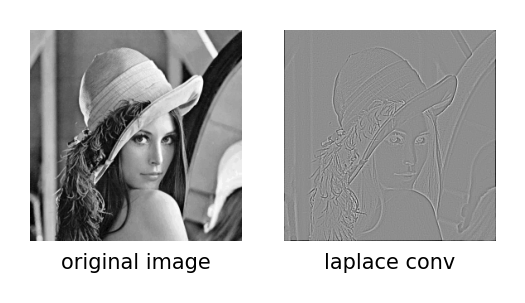

In [ ]:
# 取消注释并完成程序填空题后运行
# # 1、定义Laplace卷积核
# # 利用np.array()工具完成Laplace卷积核kernel_laplace的定义工作（预计代码行数：1行）


# weight_laplace = kernel_laplace.reshape(
#     1, 1, kernel_laplace.shape[0], kernel_laplace.shape[1])

# # 2、定义卷积参数：
# para_dict_laplace = {"pad_h": int((kernel_laplace.shape[0]-1)/2), "pad_w": int((kernel_laplace.shape[1]-1)/2),
#                      "stride_h": 1, "stride_w": 1}

# # 3、实现卷积
# res_laplace = conv_compute(data_img, weight_laplace, para_dict_laplace)

# # 4、可视化卷积结果
# plt.figure(dpi=300, figsize=(2, 1))
# plt.subplot(1, 2, 1)
# plt.axis('off')
# plt.title('original image', y=-0.25, size=5)
# plt.imshow(img, cmap=plt.get_cmap('gray'))

# plt.subplot(1, 2, 2)
# plt.axis('off')
# plt.title('laplace conv', y=-0.25, size=5)
# plt.imshow(res_laplace[0, 0, :, :], cmap=plt.get_cmap('gray'))

# plt.show()

### 参考解答

In [ ]:
# ###定义Laplace卷积核
# kernel_laplace = np.array([[1, 1, 1],
#                            [1, -8, 1],
#                            [1, 1, 1]])

### 7.2 实验任务2 不同尺寸卷积核下的卷积效果展示

### 实验任务

卷积核被用来学习和检测数据的特征，卷积核的尺寸限制卷积核的单次检测和识别范围，即：感受野。在卷积核的尺寸设置上通常有：3 $\times$ 3、5 $\times$ 5、7 $\times$ 7等。通过补写下面的代码，完成均值卷积运算中3 $\times$ 3和7 $\times$ 7大小的卷积核对图像的卷积结果展示。

可能用到的编程技巧提示：

（1）对于均值卷积算子的定义可以用numpy的.ones()方法实现，例如定义一个X $\times$ X大小的均值卷积核：

`kernel = np.ones((X,X))/X^2`

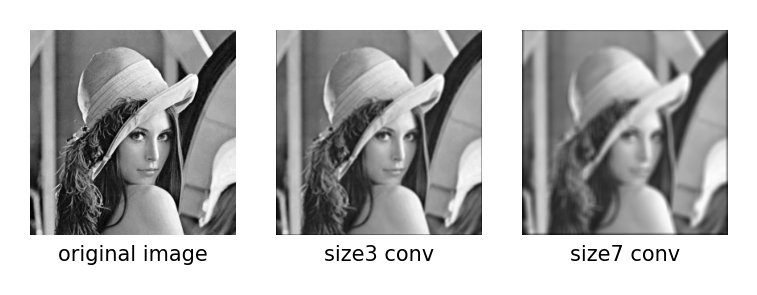

In [ ]:
#取消注释并完成程序填空题后运行
# # 1、分别定义3*3 和7*7大小的卷积核
# # 完成kernel_size7、kernel_size7、weight_size3、weight_size7的定义工作（预计代码行数：4行）


# # 2、分别定义两种卷积运算下需要用到的卷积参数：
# para_dict_size3 = {"pad_h": int((kernel_size3.shape[0]-1)/2), "pad_w": int((kernel_size3.shape[1]-1)/2),
#                    "stride_h": 1, "stride_w": 1}
# para_dict_size7 = {"pad_h": int((kernel_size7.shape[0]-1)/2), "pad_w": int((kernel_size7.shape[1]-1)/2),
#                    "stride_h": 1, "stride_w": 1}

# # 3、实现卷积
# # 完成获取卷积结果res_size3、res_size7的工作（预计代码行数：2行）


# # 4、可视化卷积结果
# plt.figure(dpi=300, figsize=(3, 1))
# plt.subplot(1, 3, 1)
# plt.axis('off')
# plt.title('original image', y=-0.25, size=5)
# plt.imshow(img, cmap=plt.get_cmap('gray'))

# plt.subplot(1, 3, 2)
# plt.axis('off')
# plt.title('size3 conv', y=-0.25, size=5)
# plt.imshow(res_size3[0, 0, :, :], cmap=plt.get_cmap('gray'))

# plt.subplot(1, 3, 3)
# plt.axis('off')
# plt.title('size7 conv', y=-0.25, size=5)
# plt.imshow(res_size7[0, 0, :, :], cmap=plt.get_cmap('gray'))

# plt.show()

### 参考解答

In [ ]:
# ### 完成kernel_size7、kernel_size7、weight_size3、weight_size7的定义工作
# kernel_size3 = np.ones((3, 3))/9
# kernel_size7 = np.ones((7, 7))/49
# weight_size3 = kernel_size3.reshape((1, 1, kernel_size3.shape[0], kernel_size3.shape[1]))
# weight_size7 = kernel_size7.reshape((1, 1, kernel_size7.shape[0], kernel_size7.shape[1]))


# ### 完成获取卷积结果res_size3、res_size7的工作
# res_size3 = conv_compute(data_img, weight_size3, para_dict_size3)
# res_size7 = conv_compute(data_img, weight_size7, para_dict_size7)

### 7.3 实验任务3 卷积步长stride参数

### 实验任务

stride参数用于控制卷积步长，通过控制stride参数可以控制特征提取的精度并成倍压缩数据的尺寸大小，通过补写下面的代码完成步长为2的卷积结果展示。

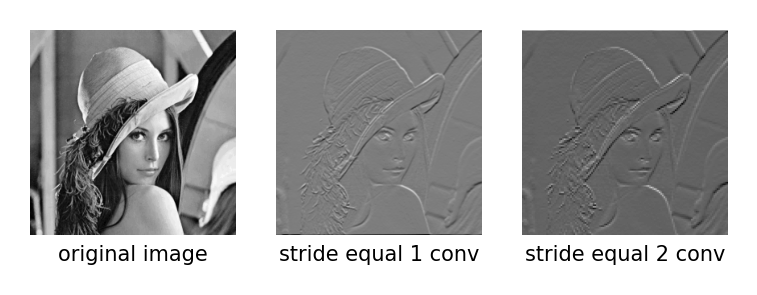

卷积前数据的大小：  (1, 1, 256, 256)
stride为1卷积后数据的大小：  (1, 1, 256, 256)
stride为2卷积后数据的大小：  (1, 1, 128, 128)


In [ ]:
#取消注释并完成程序填空题后运行
# # 1、定义步长为1和2的卷积参数：
# para_dict_stride1 = {"pad_h": int((kernel_rand.shape[0]-1)/2), "pad_w": int((kernel_rand.shape[1]-1)/2),
#                      "stride_h": 1, "stride_w": 1}
# ### 完成定义步长为2的卷积参数para_dict_stride2的工作（预计代码行数：1行）


# # 2、实现卷积
# res_stride1 = conv_compute(data_img, weight_sobel,
#                            para_dict_stride1)  # 卷积核采用之前定义的sobel卷积核
# res_stride2 = conv_compute(data_img, weight_sobel, para_dict_stride2)


# # 3、可视化不同步长下卷积的结果并输出数据大小
# plt.figure(dpi=300, figsize=(3, 1))
# plt.subplot(1, 3, 1)
# plt.axis('off')
# plt.title('original image', y=-0.25, size=5)
# plt.imshow(img, cmap=plt.get_cmap('gray'))

# plt.subplot(1, 3, 2)
# plt.axis('off')
# plt.title('stride equal 1 conv', y=-0.25, size=5)
# plt.imshow(res_stride1[0, 0, :, :], cmap=plt.get_cmap('gray'))

# plt.subplot(1, 3, 3)
# plt.axis('off')
# plt.title('stride equal 2 conv', y=-0.25, size=5)
# plt.imshow(res_stride2[0, 0, :, :], cmap=plt.get_cmap('gray'))

# plt.show()

# print('卷积前数据的大小： ', data_img.shape)
# print('stride为1卷积后数据的大小： ', res_stride1.shape)
# print('stride为2卷积后数据的大小： ', res_stride2.shape)

### 参考解答

In [ ]:
# ### 完成定义步长为2的卷积参数para_dict_stride2的工作
# para_dict_stride2 = {"pad_h":int((kernel_rand.shape[0]-1)/2), "pad_w":int((kernel_rand.shape[1]-1)/2),
#                      "stride_h":2, "stride_w":2}

### 7.4 实验任务4 square算子的TBE自定义算子开发

### 实验任务

根据add3算子的TBE DSL实现样例，采用DSL开发方式实现**square算子**的自定义算子开发。

**square算子功能**：对于一个输入张量，算子输出为对输入张量各元素进行开平方运算的结果。如当输入为[1.0, 4.0, 9.0]时，算子输出应为[1.0, 16.0, 81.0]。

**提示**：DSL API接口te.lang.cce.vmul的功能为实现两个tensor按元素相乘，其具体使用方法见[TBE DSL API-vmul](https://support.huawei.com/enterprise/zh/doc/EDOC1100192206/db16c3cb#ZH-CN_TOPIC_0000001073202354)

### 参考解答

首先进行算子原语注册，**cus_square.py**文件代码如下。

In [ ]:
#取消注释后运行
# %%writefile cus_square.py
# ###算子原语注册
# from mindspore.ops import prim_attr_register, PrimitiveWithInfer

# class CusSquare(PrimitiveWithInfer):
#     """CusSquare definition"""
#     @prim_attr_register
#     def __init__(self):
#         """init CusSquare"""
#         self.init_prim_io_names(inputs=['x'], outputs=['y'])
#         from square_impl import CusSquareImpl

#     def infer_shape(self, x):
#         return x

#     def infer_dtype(self, x):
#         return x

Writing cus_square.py


然后进行算子实现和算子信息注册，**square_impl.py**文件代码如下。

In [ ]:
#取消注释后运行
# %%writefile square_impl.py
# from __future__ import absolute_import

# import te.lang.cce
# from te import tvm
# from te.platform.fusion_manager import fusion_manager
# from topi import generic
# from topi.cce import util

# from mindspore.ops.op_info_register import op_info_register, TBERegOp, DataType

# @fusion_manager.register("square")
# def square_compute(input_x):
#     res = te.lang.cce.vmul(input_x, input_x)
#     return res


# cus_square_op_info = TBERegOp("CusSquare") \
#     .fusion_type("OPAQUE") \
#     .async_flag(False) \
#     .binfile_name("square.so") \
#     .compute_cost(10) \
#     .kernel_name("CusSquareImpl") \
#     .partial_flag(True) \
#     .input(0, "x", False, "required", "all") \
#     .output(0, "y", False, "required", "all") \
#     .dtype_format(DataType.F32_Default, DataType.F32_Default) \
#     .dtype_format(DataType.F16_Default, DataType.F16_Default) \
#     .get_op_info()


# @op_info_register(cus_square_op_info)
# def CusSquareImpl(input_x, output_y, kernel_name="CusSquareImpl"):

#     shape = input_x.get("shape")
#     dtype = input_x.get("dtype").lower()

#     shape = util.shape_refine(shape)
#     data = tvm.placeholder(shape, name="data", dtype=dtype.lower())

#     with tvm.target.cce():
#         res = square_compute(data)
#         sch = generic.auto_schedule(res)

#     config = {"print_ir": False,
#               "name": kernel_name,
#               "tensor_list": [data, res]}

#     te.lang.cce.cce_build_code(sch, config)

Writing square_impl.py


最后对实现的square算子进行功能测试，测试代码如下。

In [ ]:
import numpy as np
from cus_square import CusSquare

import mindspore.context as context
import mindspore.nn as nn
from mindspore import Tensor
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")

class Net(nn.Cell):
    """Net definition"""

    def __init__(self):
        super(Net, self).__init__()
        self.square = CusSquare()

    def construct(self, data):
        return self.square(data)

def test_net():
    x = np.array([1.0, 4.0, 9.0]).astype(np.float32)
    square = Net()
    output = square(Tensor(x))
    print("output: ", output)
    expect = np.array([1.0, 16.0, 81.0]).astype(np.float32)
    assert (output.asnumpy() == expect).all()

运行下面测试用例，测试算子的正确性

执行用例：

In [ ]:
test_net()